In [1]:
# Libraries

import argparse
import os
import platform
import itertools
import ray
import shutil
import sys

In [2]:
# Ensure source path

ROOT = os.getcwd()

while not ROOT.endswith('upolanc-thesis') :
	ROOT = os.path.abspath(os.path.join(ROOT, os.pardir))

	if len(ROOT) < len('upolanc-thesis') :
		if   platform.system() == 'Linux' :
			ROOT = '/d/hpc/home/up4472/workspace/upolanc-thesis'
		elif platform.system() == 'Windows' :
			ROOT = 'C:\\Developer\\Workspace\\PyCharm\\Projects\\upolanc-thesis'
		else :
			raise ValueError()

		print(f'Warning : could not find correct directory, using default : {ROOT}')
		break

if ROOT not in sys.path :
	sys.path.append(ROOT)

os.chdir(ROOT)

In [3]:
# Tuner

ray.init(include_dashboard = False)

from ray.tune import choice
from ray.tune import uniform
from ray.tune import loguniform
from ray.tune import randint
from ray.tune import grid_search

2023-05-12 14:40:46,641	INFO worker.py:1538 -- Started a local Ray instance.


In [4]:
# Code

from source.python.raytune import raytune_data
from source.python.raytune import raytune_model
from source.python.raytune import raytune_plot
from source.python.raytune import raytune_utils
from source.python.io      import loader
from source.python         import runtime

runtime.set_numpy_format()
runtime.set_pandas_format()
runtime.set_plot_theme()

(pid=) C:\Developer\Workspace\PyCharm\Environments\upolanc-thesis\lib\site-packages\ray\dashboard\agent.py:51: DeprecationWarning: There is no current event loop
(pid=)   aiogrpc.init_grpc_aio()


# 1. Setup

In [5]:
# Define output and inputs

MODEL_NAME       = 'zrimec2020'
MODEL_TYPE       = 'r'
MODEL_MODE       = None
MODEL_PARAMS     = None
MODEL_EPOCHS     = 5

TARGET_GROUP     = 'global'
TARGET_TYPE      = 'mean'
TARGET_EXPLODE   = False
TARGET_FILTER    = None

TUNER_CONCURRENT = 1
TUNER_TRIALS     = 5
TUNER_GRACE      = 1
TUNER_NOTEBOOK   = True
TUNER_SEARCH     = 'hyperopt'

FILTER_ID        = 0

GENERATOR        = 'group'
FEATURES         = True

SEQUENCE_END     = None
SEQUENCE_START   = None

In [6]:
# Check for args

if __name__ == '__main__' and 'get_ipython' in dir() :
	print('Running as .ipynb')

if __name__ == '__main__' and 'get_ipython' not in dir() :
	print('Running as .py')

	parser = argparse.ArgumentParser()

	str_of_bool = lambda x : True if x == 'true' else False
	str_or_none = lambda x : None if x == 'none' else str(x)

	_target_groups    = ['tissue', 'group', 'age', 'global', 'perturbation']
	_target_types     = ['mean', 'max']
	_model_names      = ['washburn2019', 'zrimec2020']
	_model_types      = ['r', 'c']
	_tuner_search     = ['hyperopt', 'gridsearch']
	_split_generators = ['stratified', 'group', 'random']

	parser.add_argument('--target_group',     type = str,         default = 'global',     choices = _target_groups)
	parser.add_argument('--target_type',      type = str,         default = 'mean',       choices = _target_types)
	parser.add_argument('--target_explode',   type = str_of_bool, default = False)
	parser.add_argument('--target_filter',    type = str_or_none, default = None)
	parser.add_argument('--model_name',       type = str,         default = 'zrimec2020', choices = _model_names)
	parser.add_argument('--model_type',       type = str,         default = 'r',          choices = _model_types)
	parser.add_argument('--model_epochs',     type = int,         default = 500)
	parser.add_argument('--tuner_search',     type = str,         default = 'hyperopt',   choices = _tuner_search)
	parser.add_argument('--tuner_concurrent', type = int,         default = 5)
	parser.add_argument('--tuner_trials',     type = int,         default = 250)
	parser.add_argument('--tuner_grace',      type = int,         default = 10)
	parser.add_argument('--filter_id',        type = int,         default = 0)
	parser.add_argument('--generator',        type = str,         default = 'group',      choices = _split_generators)
	parser.add_argument('--features',         type = str_of_bool, default = True)

	args = vars(parser.parse_args())

	TARGET_GROUP     = args['target_group']
	TARGET_TYPE      = args['target_type']
	TARGET_EXPLODE   = args['target_explode']
	TARGET_FILTER    = args['target_filter']
	MODEL_NAME       = args['model_name']
	MODEL_TYPE       = args['model_type']
	MODEL_EPOCHS     = args['model_epochs']
	TUNER_CONCURRENT = args['tuner_concurrent']
	TUNER_TRIALS     = args['tuner_trials']
	TUNER_GRACE      = args['tuner_grace']
	TUNER_SEARCH     = args['tuner_search']
	FILTER_ID        = args['filter_id']
	GENERATOR        = args['generator']
	FEATURES         = args['features']

	TUNER_NOTEBOOK   = False

if TARGET_GROUP == 'global' :
	TARGET_EXPLODE = False

if MODEL_TYPE == 'r' : MODEL_MODE = 'regression'
if MODEL_TYPE == 'c' : MODEL_MODE = 'classification'

Running as .ipynb


In [7]:
# Setup some directory paths.

SUBFOLDER = 'filter' + str(FILTER_ID)

CWD = ROOT
OUT = os.path.join(CWD, 'output')
RES = os.path.join(CWD, 'resources')

OUT_DATA  = os.path.join(OUT,      'nbp06-tuner', 'data', SUBFOLDER, MODEL_NAME[:-4])
OUT_PLOT  = os.path.join(OUT_DATA, 'plot')
RES_TUNER = os.path.join(RES,      'tuner')
RES_NBP04 = os.path.join(OUT,      'nbp04-feature', SUBFOLDER)
RES_NBP05 = os.path.join(OUT,      'nbp05-target',  SUBFOLDER)

shutil.rmtree(OUT_DATA, ignore_errors = True)

os.makedirs(OUT_DATA, exist_ok = True)
os.makedirs(OUT_PLOT, exist_ok = True)

print(f'     Root Directory : {CWD}')
print(f'   Output Directory : {OUT_DATA}')
print(f'   Output Directory : {OUT_PLOT}')
print(f' Resource Directory : {RES_TUNER}')
print(f' Resource Directory : {RES_NBP04}')
print(f' Resource Directory : {RES_NBP05}')

     Root Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis
   Output Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp06-tuner\data\filter0\zrimec
   Output Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp06-tuner\data\filter0\zrimec\plot
 Resource Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\resources\tuner
 Resource Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp04-feature\filter0
 Resource Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp05-target\filter0


In [8]:
# System and device

DEVICE = runtime.get_device(only_cpu = False)
SYSTEM = runtime.get_system_info()

for key, value in SYSTEM.items() :
	print('{:25s} : {}'.format(key, value))

platform/python           : 3.10.7
platform/system           : Windows
platform/release          : 10
platform/version          : 10.0.19044
platform/cpu/name         : N/A
platform/cpu/count        : 12
platform/gpu/name         : NVIDIA GeForce RTX 3060 Ti
platform/gpu/available    : True
platform/gpu/count        : 1
platform/memory/total     : 31.924 GB
platform/memory/available : 13.449 GB


# 2. Tuner

In [9]:
# Define basic data parameters

CONFIG = {
	'core/device'             : DEVICE,
	'core/outdir'             : OUT_DATA,
	'core/random'             : None,
	'core/rootdir'            : ROOT,
	'core/subfolder'          : SUBFOLDER,
	'dataset/expanddim'       : None,
	'dataset/filepath'        : os.path.join(OUT_DATA, 'dataset.pkl'),
	'dataset/sequence/start'  : SEQUENCE_START,
	'dataset/sequence/end'    : SEQUENCE_END,
	'dataset/split/generator' : GENERATOR,
	'dataset/split/test'      : 0.2,
	'dataset/split/valid'     : 0.2,
	'model/epochs'            : MODEL_EPOCHS,
	'model/features'          : FEATURES,
	'model/input/channels'    : 1,
	'model/input/features'    : None,
	'model/input/height'      : 4,
	'model/input/width'       : 2150,
	'model/mode'              : MODEL_MODE,
	'model/name'              : MODEL_NAME,
	'model/output/explode'    : TARGET_EXPLODE,
	'model/output/filter'     : TARGET_FILTER,
	'model/output/heads'      : None,
	'model/output/size'       : None,
	'model/output/target'     : TARGET_GROUP,
	'model/output/type'       : TARGET_TYPE,
	'model/type'              : MODEL_NAME + MODEL_TYPE,
	'params/filepath'         : RES_TUNER,
	'params/tuner'            : None,
	'tuner/checkpoint'        : False,
	'tuner/max_concurrent'    : TUNER_CONCURRENT,
	'tuner/max_epochs'        : MODEL_EPOCHS,
	'tuner/min_epochs'        : TUNER_GRACE,
	'tuner/reporter/freq'     : 30,
	'tuner/reporter/notebook' : TUNER_NOTEBOOK,
	'tuner/search'            : TUNER_SEARCH,
	'tuner/stopper'           : True,
	'tuner/stopper/days'      : 3,
	'tuner/stopper/hours'     : 22,
	'tuner/stopper/minutes'   : 0,
	'tuner/trials'            : TUNER_TRIALS
}

CONFIG['core/random'] = runtime.lock_random(
	seed     = CONFIG['core/random'],
	generate = True
)

if CONFIG['model/name'].startswith('washburn2019') :
	CONFIG['dataset/expanddim'] = 0

In [10]:
# Prints

print('Model Name      : {}'.format(CONFIG['model/name']))
print('Model Type      : {}'.format(CONFIG['model/type']))
print('Model Mode      : {}'.format(CONFIG['model/mode']))
print('Use Features    : {}'.format(CONFIG['model/features']))
print('Split Generator : {}'.format(CONFIG['dataset/split/generator']))
print('Random Seed     : {}'.format(CONFIG['core/random']))

Model Name      : zrimec2020
Model Type      : zrimec2020r
Model Mode      : regression
Use Features    : True
Split Generator : group
Random Seed     : 104697559


# 3. Search Space

In [11]:
# Define search space

MIN_BINS = 2
MAX_BINS = 5

param_space = dict()

param_space['boxcox/lambda'] = uniform(-0.6, 0.2)
param_space['class/bins']    = randint(MIN_BINS, MAX_BINS)

if CONFIG['tuner/search'] == 'gridsearch' :
	param_space['class/bins'] = grid_search(list(range(MIN_BINS, MAX_BINS)))

# 4. Tuning

In [12]:
# Create initial params

FORCE_LAMBDA = [-0.14552661101589698, 0.00000000000000000]
FORCE_BINS   = None

if CONFIG['model/mode'] == 'classification' :
	FORCE_BINS = list(range(MIN_BINS, MAX_BINS))
else :
	FORCE_BINS = [3]

PARAMS = list()

for item in itertools.product(FORCE_LAMBDA, FORCE_BINS) :
	PARAMS.append({
		'boxcox/lambda' : item[0],
		'class/bins'    : item[1]
	})

In [13]:
# Create tuner config

trainable = raytune_utils.create_trainable(
	method    = raytune_data.main,
	config    = CONFIG,
	cpu_count = SYSTEM['platform/cpu/count'],
	gpu_count = SYSTEM['platform/gpu/count']
)

tune_config = raytune_utils.create_tune_config(
	config    = CONFIG,
	algorithm = CONFIG['tuner/search'],
	params    = PARAMS
)

run_config = raytune_utils.create_run_config(
	config    = CONFIG,
	local_dir = OUT_DATA,
	verbosity = raytune_utils.VERBOSE_STATUS,
	task      = 'data'
)

In [14]:
# Create tune and fit

tuner = raytune_utils.create_tuner(
	trainable   = trainable,
	tune_config = tune_config,
	run_config  = run_config,
	param_space = param_space
)

report = tuner.fit()

(<lambda> pid=21952) C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\source\python\raytune\raytune_data.py:165: RuntimeWarning: All-NaN slice encountered
(<lambda> pid=21952)   ('max',  lambda x, axis : numpy.nanmax(x, axis = axis)),


(<lambda> pid=21952) Filtered out [  0.2869 %] percent with mean change [  0.8927 %] from [Tissue] [max] [flower]
(<lambda> pid=21952) Filtered out [  0.4262 %] percent with mean change [ 10.2171 %] from [Tissue] [max] [leaf]
(<lambda> pid=21952) Filtered out [  0.4604 %] percent with mean change [  4.2032 %] from [Tissue] [max] [root]
(<lambda> pid=21952) Filtered out [  0.4269 %] percent with mean change [  1.5400 %] from [Tissue] [max] [seed]
(<lambda> pid=21952) Filtered out [  0.3149 %] percent with mean change [  6.5301 %] from [Tissue] [max] [seedling]


(<lambda> pid=21952) C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\source\python\raytune\raytune_data.py:166: RuntimeWarning: Mean of empty slice
(<lambda> pid=21952)   ('mean', lambda x, axis : numpy.nanmean(x, axis = axis))


(<lambda> pid=21952) Filtered out [  0.2869 %] percent with mean change [  0.0372 %] from [Tissue] [mean] [flower]
(<lambda> pid=21952) Filtered out [  0.4262 %] percent with mean change [  0.3457 %] from [Tissue] [mean] [leaf]
(<lambda> pid=21952) Filtered out [  0.4604 %] percent with mean change [  0.2897 %] from [Tissue] [mean] [root]
(<lambda> pid=21952) Filtered out [  0.4269 %] percent with mean change [  0.0913 %] from [Tissue] [mean] [seed]
(<lambda> pid=21952) Filtered out [  0.3149 %] percent with mean change [  0.2548 %] from [Tissue] [mean] [seedling]
(<lambda> pid=21952) Filtered out [  0.3564 %] percent with mean change [  8.8977 %] from [Age] [max] [mature]
(<lambda> pid=21952) Filtered out [  0.5413 %] percent with mean change [  2.8638 %] from [Age] [max] [missing]


(<lambda> pid=21952) C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\source\python\raytune\raytune_data.py:165: RuntimeWarning: All-NaN slice encountered
(<lambda> pid=21952)   ('max',  lambda x, axis : numpy.nanmax(x, axis = axis)),


(<lambda> pid=21952) Filtered out [  0.4123 %] percent with mean change [  0.6728 %] from [Age] [max] [seed]
(<lambda> pid=21952) Filtered out [  0.2018 %] percent with mean change [  6.0019 %] from [Age] [max] [young]
(<lambda> pid=21952) Filtered out [  0.3564 %] percent with mean change [  0.3964 %] from [Age] [mean] [mature]
(<lambda> pid=21952) Filtered out [  0.5413 %] percent with mean change [  0.6408 %] from [Age] [mean] [missing]
(<lambda> pid=21952) Filtered out [  0.4123 %] percent with mean change [  0.1301 %] from [Age] [mean] [seed]


(<lambda> pid=21952) C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\source\python\raytune\raytune_data.py:166: RuntimeWarning: Mean of empty slice
(<lambda> pid=21952)   ('mean', lambda x, axis : numpy.nanmean(x, axis = axis))


(<lambda> pid=21952) Filtered out [  0.2018 %] percent with mean change [  0.1827 %] from [Age] [mean] [young]


(<lambda> pid=21952) C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\source\python\raytune\raytune_data.py:165: RuntimeWarning: All-NaN slice encountered
(<lambda> pid=21952)   ('max',  lambda x, axis : numpy.nanmax(x, axis = axis)),


(<lambda> pid=21952) Filtered out [  0.2565 %] percent with mean change [  0.6555 %] from [Group] [max] [mature_flower]
(<lambda> pid=21952) Filtered out [  0.4293 %] percent with mean change [ 10.0825 %] from [Group] [max] [mature_leaf]
(<lambda> pid=21952) Filtered out [  0.5007 %] percent with mean change [  3.1342 %] from [Group] [max] [mature_root]
(<lambda> pid=21952) Filtered out [  0.4269 %] percent with mean change [  1.5400 %] from [Group] [max] [mature_seed]
(<lambda> pid=21952) Filtered out [  0.3068 %] percent with mean change [  5.7496 %] from [Group] [max] [mature_seedling]
(<lambda> pid=21952) Filtered out [  0.6801 %] percent with mean change [  0.4434 %] from [Group] [max] [missing_flower]
(<lambda> pid=21952) Filtered out [  1.0511 %] percent with mean change [  2.9921 %] from [Group] [max] [missing_leaf]
(<lambda> pid=21952) Filtered out [  1.8604 %] percent with mean change [  1.3059 %] from [Group] [max] [missing_root]
(<lambda> pid=21952) Filtered out [  3.4707 %

(<lambda> pid=21952) C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\source\python\raytune\raytune_data.py:166: RuntimeWarning: Mean of empty slice
(<lambda> pid=21952)   ('mean', lambda x, axis : numpy.nanmean(x, axis = axis))


(<lambda> pid=21952) Filtered out [  0.2565 %] percent with mean change [  0.0200 %] from [Group] [mean] [mature_flower]
(<lambda> pid=21952) Filtered out [  0.4293 %] percent with mean change [  0.3546 %] from [Group] [mean] [mature_leaf]
(<lambda> pid=21952) Filtered out [  0.5007 %] percent with mean change [  0.2528 %] from [Group] [mean] [mature_root]
(<lambda> pid=21952) Filtered out [  0.4269 %] percent with mean change [  0.0913 %] from [Group] [mean] [mature_seed]
(<lambda> pid=21952) Filtered out [  0.3068 %] percent with mean change [  0.2081 %] from [Group] [mean] [mature_seedling]
(<lambda> pid=21952) Filtered out [  0.6801 %] percent with mean change [  0.5717 %] from [Group] [mean] [missing_flower]
(<lambda> pid=21952) Filtered out [  1.0511 %] percent with mean change [  0.5005 %] from [Group] [mean] [missing_leaf]
(<lambda> pid=21952) Filtered out [  1.8604 %] percent with mean change [  1.6586 %] from [Group] [mean] [missing_root]
(<lambda> pid=21952) Filtered out [  

(<lambda> pid=21952) C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\source\python\raytune\raytune_data.py:165: RuntimeWarning: All-NaN slice encountered
(<lambda> pid=21952)   ('max',  lambda x, axis : numpy.nanmax(x, axis = axis)),


(<lambda> pid=21952) Filtered out [  0.2881 %] percent with mean change [  4.0476 %] from [Perturbation] [max] [chemical]
(<lambda> pid=21952) Filtered out [  0.3267 %] percent with mean change [  7.3540 %] from [Perturbation] [max] [control]
(<lambda> pid=21952) Filtered out [  0.9086 %] percent with mean change [  0.4498 %] from [Perturbation] [max] [dna]
(<lambda> pid=21952) Filtered out [  0.3617 %] percent with mean change [  7.4280 %] from [Perturbation] [max] [environmental]
(<lambda> pid=21952) Filtered out [  0.6968 %] percent with mean change [  2.0134 %] from [Perturbation] [max] [mechanical]
(<lambda> pid=21952) Filtered out [  0.4439 %] percent with mean change [  6.1529 %] from [Perturbation] [max] [mutant]
(<lambda> pid=21952) Filtered out [  0.3036 %] percent with mean change [  6.2981 %] from [Perturbation] [max] [unstressed]


(<lambda> pid=21952) C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\source\python\raytune\raytune_data.py:166: RuntimeWarning: Mean of empty slice
(<lambda> pid=21952)   ('mean', lambda x, axis : numpy.nanmean(x, axis = axis))


(<lambda> pid=21952) Filtered out [  0.2881 %] percent with mean change [  0.1479 %] from [Perturbation] [mean] [chemical]
(<lambda> pid=21952) Filtered out [  0.3267 %] percent with mean change [  0.3731 %] from [Perturbation] [mean] [control]
(<lambda> pid=21952) Filtered out [  0.9086 %] percent with mean change [  0.7395 %] from [Perturbation] [mean] [dna]
(<lambda> pid=21952) Filtered out [  0.3617 %] percent with mean change [  0.3589 %] from [Perturbation] [mean] [environmental]
(<lambda> pid=21952) Filtered out [  0.6968 %] percent with mean change [  0.1247 %] from [Perturbation] [mean] [mechanical]
(<lambda> pid=21952) Filtered out [  0.4439 %] percent with mean change [  0.5872 %] from [Perturbation] [mean] [mutant]
(<lambda> pid=21952) Filtered out [  0.3036 %] percent with mean change [  0.3201 %] from [Perturbation] [mean] [unstressed]


(<lambda> pid=22948) C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\source\python\raytune\raytune_data.py:165: RuntimeWarning: All-NaN slice encountered
(<lambda> pid=22948)   ('max',  lambda x, axis : numpy.nanmax(x, axis = axis)),


(<lambda> pid=22948) Filtered out [  0.3360 %] percent with mean change [  1.1614 %] from [Tissue] [max] [flower]
(<lambda> pid=22948) Filtered out [  0.5239 %] percent with mean change [ 13.6612 %] from [Tissue] [max] [leaf]
(<lambda> pid=22948) Filtered out [  0.5788 %] percent with mean change [  6.1146 %] from [Tissue] [max] [root]
(<lambda> pid=22948) Filtered out [  0.4927 %] percent with mean change [  2.1658 %] from [Tissue] [max] [seed]
(<lambda> pid=22948) Filtered out [  0.4376 %] percent with mean change [  9.8944 %] from [Tissue] [max] [seedling]


(<lambda> pid=22948) C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\source\python\raytune\raytune_data.py:166: RuntimeWarning: Mean of empty slice
(<lambda> pid=22948)   ('mean', lambda x, axis : numpy.nanmean(x, axis = axis))


(<lambda> pid=22948) Filtered out [  0.3360 %] percent with mean change [  0.0684 %] from [Tissue] [mean] [flower]
(<lambda> pid=22948) Filtered out [  0.5239 %] percent with mean change [  0.4964 %] from [Tissue] [mean] [leaf]
(<lambda> pid=22948) Filtered out [  0.5788 %] percent with mean change [  0.4465 %] from [Tissue] [mean] [root]
(<lambda> pid=22948) Filtered out [  0.4927 %] percent with mean change [  0.1725 %] from [Tissue] [mean] [seed]
(<lambda> pid=22948) Filtered out [  0.4376 %] percent with mean change [  0.4059 %] from [Tissue] [mean] [seedling]
(<lambda> pid=22948) Filtered out [  0.4760 %] percent with mean change [ 13.3381 %] from [Age] [max] [mature]
(<lambda> pid=22948) Filtered out [  0.6396 %] percent with mean change [  3.6304 %] from [Age] [max] [missing]
(<lambda> pid=22948) Filtered out [  0.4578 %] percent with mean change [  1.0709 %] from [Age] [max] [seed]


(<lambda> pid=22948) C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\source\python\raytune\raytune_data.py:165: RuntimeWarning: All-NaN slice encountered
(<lambda> pid=22948)   ('max',  lambda x, axis : numpy.nanmax(x, axis = axis)),


(<lambda> pid=22948) Filtered out [  0.2835 %] percent with mean change [  8.0457 %] from [Age] [max] [young]
(<lambda> pid=22948) Filtered out [  0.4760 %] percent with mean change [  0.5767 %] from [Age] [mean] [mature]
(<lambda> pid=22948) Filtered out [  0.6396 %] percent with mean change [  0.7899 %] from [Age] [mean] [missing]
(<lambda> pid=22948) Filtered out [  0.4578 %] percent with mean change [  0.0881 %] from [Age] [mean] [seed]


(<lambda> pid=22948) C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\source\python\raytune\raytune_data.py:166: RuntimeWarning: Mean of empty slice
(<lambda> pid=22948)   ('mean', lambda x, axis : numpy.nanmean(x, axis = axis))


(<lambda> pid=22948) Filtered out [  0.2835 %] percent with mean change [  0.2860 %] from [Age] [mean] [young]


(<lambda> pid=22948) C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\source\python\raytune\raytune_data.py:165: RuntimeWarning: All-NaN slice encountered
(<lambda> pid=22948)   ('max',  lambda x, axis : numpy.nanmax(x, axis = axis)),


(<lambda> pid=22948) Filtered out [  0.2928 %] percent with mean change [  0.8205 %] from [Group] [max] [mature_flower]
(<lambda> pid=22948) Filtered out [  0.5290 %] percent with mean change [ 13.5225 %] from [Group] [max] [mature_leaf]
(<lambda> pid=22948) Filtered out [  0.6184 %] percent with mean change [  4.4187 %] from [Group] [max] [mature_root]
(<lambda> pid=22948) Filtered out [  0.4927 %] percent with mean change [  2.1658 %] from [Group] [max] [mature_seed]
(<lambda> pid=22948) Filtered out [  0.4226 %] percent with mean change [  8.6045 %] from [Group] [max] [mature_seedling]
(<lambda> pid=22948) Filtered out [  0.6873 %] percent with mean change [  0.4421 %] from [Group] [max] [missing_flower]
(<lambda> pid=22948) Filtered out [  1.1010 %] percent with mean change [  3.4633 %] from [Group] [max] [missing_leaf]
(<lambda> pid=22948) Filtered out [  1.8685 %] percent with mean change [  1.3196 %] from [Group] [max] [missing_root]
(<lambda> pid=22948) Filtered out [  3.4885 %

(<lambda> pid=22948) C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\source\python\raytune\raytune_data.py:166: RuntimeWarning: Mean of empty slice
(<lambda> pid=22948)   ('mean', lambda x, axis : numpy.nanmean(x, axis = axis))


(<lambda> pid=22948) Filtered out [  0.2928 %] percent with mean change [  0.0408 %] from [Group] [mean] [mature_flower]
(<lambda> pid=22948) Filtered out [  0.5290 %] percent with mean change [  0.5108 %] from [Group] [mean] [mature_leaf]
(<lambda> pid=22948) Filtered out [  0.6184 %] percent with mean change [  0.4021 %] from [Group] [mean] [mature_root]
(<lambda> pid=22948) Filtered out [  0.4927 %] percent with mean change [  0.1725 %] from [Group] [mean] [mature_seed]
(<lambda> pid=22948) Filtered out [  0.4226 %] percent with mean change [  0.3503 %] from [Group] [mean] [mature_seedling]
(<lambda> pid=22948) Filtered out [  0.6873 %] percent with mean change [  0.5706 %] from [Group] [mean] [missing_flower]
(<lambda> pid=22948) Filtered out [  1.1010 %] percent with mean change [  0.4620 %] from [Group] [mean] [missing_leaf]
(<lambda> pid=22948) Filtered out [  1.8685 %] percent with mean change [  1.6598 %] from [Group] [mean] [missing_root]
(<lambda> pid=22948) Filtered out [  

(<lambda> pid=22948) C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\source\python\raytune\raytune_data.py:165: RuntimeWarning: All-NaN slice encountered
(<lambda> pid=22948)   ('max',  lambda x, axis : numpy.nanmax(x, axis = axis)),


(<lambda> pid=22948) Filtered out [  0.3924 %] percent with mean change [  6.4769 %] from [Perturbation] [max] [chemical]
(<lambda> pid=22948) Filtered out [  0.4274 %] percent with mean change [ 10.7741 %] from [Perturbation] [max] [control]
(<lambda> pid=22948) Filtered out [  0.9227 %] percent with mean change [  0.4368 %] from [Perturbation] [max] [dna]
(<lambda> pid=22948) Filtered out [  0.4934 %] percent with mean change [ 10.4492 %] from [Perturbation] [max] [environmental]
(<lambda> pid=22948) Filtered out [  0.7824 %] percent with mean change [  2.9024 %] from [Perturbation] [max] [mechanical]
(<lambda> pid=22948) Filtered out [  0.5391 %] percent with mean change [  9.2864 %] from [Perturbation] [max] [mutant]
(<lambda> pid=22948) Filtered out [  0.3981 %] percent with mean change [  8.0396 %] from [Perturbation] [max] [unstressed]


(<lambda> pid=22948) C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\source\python\raytune\raytune_data.py:166: RuntimeWarning: Mean of empty slice
(<lambda> pid=22948)   ('mean', lambda x, axis : numpy.nanmean(x, axis = axis))


(<lambda> pid=22948) Filtered out [  0.3924 %] percent with mean change [  0.2795 %] from [Perturbation] [mean] [chemical]
(<lambda> pid=22948) Filtered out [  0.4274 %] percent with mean change [  0.5192 %] from [Perturbation] [mean] [control]
(<lambda> pid=22948) Filtered out [  0.9227 %] percent with mean change [  0.7367 %] from [Perturbation] [mean] [dna]
(<lambda> pid=22948) Filtered out [  0.4934 %] percent with mean change [  0.5459 %] from [Perturbation] [mean] [environmental]
(<lambda> pid=22948) Filtered out [  0.7824 %] percent with mean change [  0.0312 %] from [Perturbation] [mean] [mechanical]
(<lambda> pid=22948) Filtered out [  0.5391 %] percent with mean change [  0.7628 %] from [Perturbation] [mean] [mutant]
(<lambda> pid=22948) Filtered out [  0.3981 %] percent with mean change [  0.4512 %] from [Perturbation] [mean] [unstressed]


(<lambda> pid=21152) C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\source\python\raytune\raytune_data.py:165: RuntimeWarning: All-NaN slice encountered
(<lambda> pid=21152)   ('max',  lambda x, axis : numpy.nanmax(x, axis = axis)),


(<lambda> pid=21152) Filtered out [  0.2233 %] percent with mean change [  0.6307 %] from [Tissue] [max] [flower]
(<lambda> pid=21152) Filtered out [  0.3290 %] percent with mean change [  7.1166 %] from [Tissue] [max] [leaf]
(<lambda> pid=21152) Filtered out [  0.3222 %] percent with mean change [  2.6987 %] from [Tissue] [max] [root]
(<lambda> pid=21152) Filtered out [  0.3438 %] percent with mean change [  0.9978 %] from [Tissue] [max] [seed]
(<lambda> pid=21152) Filtered out [  0.1865 %] percent with mean change [  3.6461 %] from [Tissue] [max] [seedling]


(<lambda> pid=21152) C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\source\python\raytune\raytune_data.py:166: RuntimeWarning: Mean of empty slice
(<lambda> pid=21152)   ('mean', lambda x, axis : numpy.nanmean(x, axis = axis))


(<lambda> pid=21152) Filtered out [  0.2233 %] percent with mean change [  0.0079 %] from [Tissue] [mean] [flower]
(<lambda> pid=21152) Filtered out [  0.3290 %] percent with mean change [  0.2355 %] from [Tissue] [mean] [leaf]
(<lambda> pid=21152) Filtered out [  0.3222 %] percent with mean change [  0.1651 %] from [Tissue] [mean] [root]
(<lambda> pid=21152) Filtered out [  0.3438 %] percent with mean change [  0.0125 %] from [Tissue] [mean] [seed]
(<lambda> pid=21152) Filtered out [  0.1865 %] percent with mean change [  0.1302 %] from [Tissue] [mean] [seedling]
(<lambda> pid=21152) Filtered out [  0.2390 %] percent with mean change [  4.9320 %] from [Age] [max] [mature]
(<lambda> pid=21152) Filtered out [  0.4037 %] percent with mean change [  1.9307 %] from [Age] [max] [missing]
(<lambda> pid=21152) Filtered out [  0.3527 %] percent with mean change [  0.3581 %] from [Age] [max] [seed]


(<lambda> pid=21152) C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\source\python\raytune\raytune_data.py:165: RuntimeWarning: All-NaN slice encountered
(<lambda> pid=21152)   ('max',  lambda x, axis : numpy.nanmax(x, axis = axis)),


(<lambda> pid=21152) Filtered out [  0.1207 %] percent with mean change [  4.1755 %] from [Age] [max] [young]
(<lambda> pid=21152) Filtered out [  0.2390 %] percent with mean change [  0.2524 %] from [Age] [mean] [mature]
(<lambda> pid=21152) Filtered out [  0.4037 %] percent with mean change [  0.4521 %] from [Age] [mean] [missing]
(<lambda> pid=21152) Filtered out [  0.3527 %] percent with mean change [  0.1637 %] from [Age] [mean] [seed]


(<lambda> pid=21152) C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\source\python\raytune\raytune_data.py:166: RuntimeWarning: Mean of empty slice
(<lambda> pid=21152)   ('mean', lambda x, axis : numpy.nanmean(x, axis = axis))


(<lambda> pid=21152) Filtered out [  0.1207 %] percent with mean change [  0.0977 %] from [Age] [mean] [young]


(<lambda> pid=21152) C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\source\python\raytune\raytune_data.py:165: RuntimeWarning: All-NaN slice encountered
(<lambda> pid=21152)   ('max',  lambda x, axis : numpy.nanmax(x, axis = axis)),


(<lambda> pid=21152) Filtered out [  0.2053 %] percent with mean change [  0.4826 %] from [Group] [max] [mature_flower]
(<lambda> pid=21152) Filtered out [  0.3310 %] percent with mean change [  7.0064 %] from [Group] [max] [mature_leaf]
(<lambda> pid=21152) Filtered out [  0.3549 %] percent with mean change [  2.0652 %] from [Group] [max] [mature_root]
(<lambda> pid=21152) Filtered out [  0.3438 %] percent with mean change [  0.9978 %] from [Group] [max] [mature_seed]
(<lambda> pid=21152) Filtered out [  0.1949 %] percent with mean change [  3.4046 %] from [Group] [max] [mature_seedling]
(<lambda> pid=21152) Filtered out [  0.6701 %] percent with mean change [  0.4377 %] from [Group] [max] [missing_flower]
(<lambda> pid=21152) Filtered out [  0.9939 %] percent with mean change [  2.4950 %] from [Group] [max] [missing_leaf]
(<lambda> pid=21152) Filtered out [  1.8456 %] percent with mean change [  1.2745 %] from [Group] [max] [missing_root]
(<lambda> pid=21152) Filtered out [  3.4500 %

(<lambda> pid=21152) C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\source\python\raytune\raytune_data.py:166: RuntimeWarning: Mean of empty slice
(<lambda> pid=21152)   ('mean', lambda x, axis : numpy.nanmean(x, axis = axis))


(<lambda> pid=21152) Filtered out [  0.2053 %] percent with mean change [  0.0023 %] from [Group] [mean] [mature_flower]
(<lambda> pid=21152) Filtered out [  0.3310 %] percent with mean change [  0.2403 %] from [Group] [mean] [mature_leaf]
(<lambda> pid=21152) Filtered out [  0.3549 %] percent with mean change [  0.1308 %] from [Group] [mean] [mature_root]
(<lambda> pid=21152) Filtered out [  0.3438 %] percent with mean change [  0.0125 %] from [Group] [mean] [mature_seed]
(<lambda> pid=21152) Filtered out [  0.1949 %] percent with mean change [  0.1028 %] from [Group] [mean] [mature_seedling]
(<lambda> pid=21152) Filtered out [  0.6701 %] percent with mean change [  0.5717 %] from [Group] [mean] [missing_flower]
(<lambda> pid=21152) Filtered out [  0.9939 %] percent with mean change [  0.5297 %] from [Group] [mean] [missing_leaf]
(<lambda> pid=21152) Filtered out [  1.8456 %] percent with mean change [  1.6565 %] from [Group] [mean] [missing_root]
(<lambda> pid=21152) Filtered out [  

(<lambda> pid=21152) C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\source\python\raytune\raytune_data.py:165: RuntimeWarning: All-NaN slice encountered
(<lambda> pid=21152)   ('max',  lambda x, axis : numpy.nanmax(x, axis = axis)),


(<lambda> pid=21152) Filtered out [  0.1945 %] percent with mean change [  2.2113 %] from [Perturbation] [max] [chemical]
(<lambda> pid=21152) Filtered out [  0.2187 %] percent with mean change [  4.2017 %] from [Perturbation] [max] [control]
(<lambda> pid=21152) Filtered out [  0.8900 %] percent with mean change [  0.4593 %] from [Perturbation] [max] [dna]
(<lambda> pid=21152) Filtered out [  0.2268 %] percent with mean change [  4.8021 %] from [Perturbation] [max] [environmental]
(<lambda> pid=21152) Filtered out [  0.6007 %] percent with mean change [  1.2301 %] from [Perturbation] [max] [mechanical]
(<lambda> pid=21152) Filtered out [  0.3381 %] percent with mean change [  3.1763 %] from [Perturbation] [max] [mutant]
(<lambda> pid=21152) Filtered out [  0.2018 %] percent with mean change [  4.5194 %] from [Perturbation] [max] [unstressed]


(<lambda> pid=21152) C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\source\python\raytune\raytune_data.py:166: RuntimeWarning: Mean of empty slice
(<lambda> pid=21152)   ('mean', lambda x, axis : numpy.nanmean(x, axis = axis))


(<lambda> pid=21152) Filtered out [  0.1945 %] percent with mean change [  0.0570 %] from [Perturbation] [mean] [chemical]
(<lambda> pid=21152) Filtered out [  0.2187 %] percent with mean change [  0.2416 %] from [Perturbation] [mean] [control]
(<lambda> pid=21152) Filtered out [  0.8900 %] percent with mean change [  0.7423 %] from [Perturbation] [mean] [dna]
(<lambda> pid=21152) Filtered out [  0.2268 %] percent with mean change [  0.2094 %] from [Perturbation] [mean] [environmental]
(<lambda> pid=21152) Filtered out [  0.6007 %] percent with mean change [  0.2097 %] from [Perturbation] [mean] [mechanical]
(<lambda> pid=21152) Filtered out [  0.3381 %] percent with mean change [  0.4208 %] from [Perturbation] [mean] [mutant]
(<lambda> pid=21152) Filtered out [  0.2018 %] percent with mean change [  0.2033 %] from [Perturbation] [mean] [unstressed]


(<lambda> pid=22756) C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\source\python\raytune\raytune_data.py:165: RuntimeWarning: All-NaN slice encountered
(<lambda> pid=22756)   ('max',  lambda x, axis : numpy.nanmax(x, axis = axis)),


(<lambda> pid=22756) Filtered out [  0.3621 %] percent with mean change [  1.3314 %] from [Tissue] [max] [flower]
(<lambda> pid=22756) Filtered out [  0.5760 %] percent with mean change [ 15.6403 %] from [Tissue] [max] [leaf]
(<lambda> pid=22756) Filtered out [  0.6327 %] percent with mean change [  7.2304 %] from [Tissue] [max] [root]
(<lambda> pid=22756) Filtered out [  0.5288 %] percent with mean change [  2.5729 %] from [Tissue] [max] [seed]
(<lambda> pid=22756) Filtered out [  0.5017 %] percent with mean change [ 11.7860 %] from [Tissue] [max] [seedling]


(<lambda> pid=22756) C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\source\python\raytune\raytune_data.py:166: RuntimeWarning: Mean of empty slice
(<lambda> pid=22756)   ('mean', lambda x, axis : numpy.nanmean(x, axis = axis))


(<lambda> pid=22756) Filtered out [  0.3621 %] percent with mean change [  0.0885 %] from [Tissue] [mean] [flower]
(<lambda> pid=22756) Filtered out [  0.5760 %] percent with mean change [  0.5930 %] from [Tissue] [mean] [leaf]
(<lambda> pid=22756) Filtered out [  0.6327 %] percent with mean change [  0.5350 %] from [Tissue] [mean] [root]
(<lambda> pid=22756) Filtered out [  0.5288 %] percent with mean change [  0.2261 %] from [Tissue] [mean] [seed]
(<lambda> pid=22756) Filtered out [  0.5017 %] percent with mean change [  0.5000 %] from [Tissue] [mean] [seedling]
(<lambda> pid=22756) Filtered out [  0.5395 %] percent with mean change [ 15.8605 %] from [Age] [max] [mature]
(<lambda> pid=22756) Filtered out [  0.6906 %] percent with mean change [  4.0963 %] from [Age] [max] [missing]
(<lambda> pid=22756) Filtered out [  0.4819 %] percent with mean change [  1.3251 %] from [Age] [max] [seed]


(<lambda> pid=22756) C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\source\python\raytune\raytune_data.py:165: RuntimeWarning: All-NaN slice encountered
(<lambda> pid=22756)   ('max',  lambda x, axis : numpy.nanmax(x, axis = axis)),


(<lambda> pid=22756) Filtered out [  0.3299 %] percent with mean change [  9.2858 %] from [Age] [max] [young]
(<lambda> pid=22756) Filtered out [  0.5395 %] percent with mean change [  0.6893 %] from [Age] [mean] [mature]


(<lambda> pid=22756) C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\source\python\raytune\raytune_data.py:166: RuntimeWarning: Mean of empty slice
(<lambda> pid=22756)   ('mean', lambda x, axis : numpy.nanmean(x, axis = axis))


(<lambda> pid=22756) Filtered out [  0.6906 %] percent with mean change [  0.8735 %] from [Age] [mean] [missing]
(<lambda> pid=22756) Filtered out [  0.4819 %] percent with mean change [  0.0606 %] from [Age] [mean] [seed]
(<lambda> pid=22756) Filtered out [  0.3299 %] percent with mean change [  0.3542 %] from [Age] [mean] [young]


(<lambda> pid=22756) C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\source\python\raytune\raytune_data.py:165: RuntimeWarning: All-NaN slice encountered
(<lambda> pid=22756)   ('max',  lambda x, axis : numpy.nanmax(x, axis = axis)),


(<lambda> pid=22756) Filtered out [  0.3090 %] percent with mean change [  0.9016 %] from [Group] [max] [mature_flower]
(<lambda> pid=22756) Filtered out [  0.5809 %] percent with mean change [ 15.4841 %] from [Group] [max] [mature_leaf]
(<lambda> pid=22756) Filtered out [  0.6739 %] percent with mean change [  5.1855 %] from [Group] [max] [mature_root]
(<lambda> pid=22756) Filtered out [  0.5288 %] percent with mean change [  2.5729 %] from [Group] [max] [mature_seed]
(<lambda> pid=22756) Filtered out [  0.4800 %] percent with mean change [ 10.2160 %] from [Group] [max] [mature_seedling]
(<lambda> pid=22756) Filtered out [  0.6939 %] percent with mean change [  0.4229 %] from [Group] [max] [missing_flower]
(<lambda> pid=22756) Filtered out [  1.1263 %] percent with mean change [  3.7282 %] from [Group] [max] [missing_leaf]
(<lambda> pid=22756) Filtered out [  1.8734 %] percent with mean change [  1.3196 %] from [Group] [max] [missing_root]
(<lambda> pid=22756) Filtered out [  3.4974 %

(<lambda> pid=22756) C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\source\python\raytune\raytune_data.py:166: RuntimeWarning: Mean of empty slice
(<lambda> pid=22756)   ('mean', lambda x, axis : numpy.nanmean(x, axis = axis))


(<lambda> pid=22756) Filtered out [  0.3090 %] percent with mean change [  0.0518 %] from [Group] [mean] [mature_flower]
(<lambda> pid=22756) Filtered out [  0.5809 %] percent with mean change [  0.6094 %] from [Group] [mean] [mature_leaf]
(<lambda> pid=22756) Filtered out [  0.6739 %] percent with mean change [  0.4948 %] from [Group] [mean] [mature_root]
(<lambda> pid=22756) Filtered out [  0.5288 %] percent with mean change [  0.2261 %] from [Group] [mean] [mature_seed]
(<lambda> pid=22756) Filtered out [  0.4800 %] percent with mean change [  0.4349 %] from [Group] [mean] [mature_seedling]
(<lambda> pid=22756) Filtered out [  0.6939 %] percent with mean change [  0.5677 %] from [Group] [mean] [missing_flower]
(<lambda> pid=22756) Filtered out [  1.1263 %] percent with mean change [  0.4379 %] from [Group] [mean] [missing_leaf]
(<lambda> pid=22756) Filtered out [  1.8734 %] percent with mean change [  1.6593 %] from [Group] [mean] [missing_root]
(<lambda> pid=22756) Filtered out [  

(<lambda> pid=22756) C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\source\python\raytune\raytune_data.py:165: RuntimeWarning: All-NaN slice encountered
(<lambda> pid=22756)   ('max',  lambda x, axis : numpy.nanmax(x, axis = axis)),


(<lambda> pid=22756) Filtered out [  0.4476 %] percent with mean change [  7.9431 %] from [Perturbation] [max] [chemical]
(<lambda> pid=22756) Filtered out [  0.4814 %] percent with mean change [ 12.7591 %] from [Perturbation] [max] [control]
(<lambda> pid=22756) Filtered out [  0.9311 %] percent with mean change [  0.4212 %] from [Perturbation] [max] [dna]
(<lambda> pid=22756) Filtered out [  0.5626 %] percent with mean change [ 12.1998 %] from [Perturbation] [max] [environmental]
(<lambda> pid=22756) Filtered out [  0.8260 %] percent with mean change [  3.3997 %] from [Perturbation] [max] [mechanical]
(<lambda> pid=22756) Filtered out [  0.5882 %] percent with mean change [ 11.0577 %] from [Perturbation] [max] [mutant]
(<lambda> pid=22756) Filtered out [  0.4523 %] percent with mean change [  9.0346 %] from [Perturbation] [max] [unstressed]


(<lambda> pid=22756) C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\source\python\raytune\raytune_data.py:166: RuntimeWarning: Mean of empty slice
(<lambda> pid=22756)   ('mean', lambda x, axis : numpy.nanmean(x, axis = axis))


(<lambda> pid=22756) Filtered out [  0.4476 %] percent with mean change [  0.3644 %] from [Perturbation] [mean] [chemical]
(<lambda> pid=22756) Filtered out [  0.4814 %] percent with mean change [  0.6089 %] from [Perturbation] [mean] [control]
(<lambda> pid=22756) Filtered out [  0.9311 %] percent with mean change [  0.7340 %] from [Perturbation] [mean] [dna]
(<lambda> pid=22756) Filtered out [  0.5626 %] percent with mean change [  0.6639 %] from [Perturbation] [mean] [environmental]
(<lambda> pid=22756) Filtered out [  0.8260 %] percent with mean change [  0.0236 %] from [Perturbation] [mean] [mechanical]
(<lambda> pid=22756) Filtered out [  0.5882 %] percent with mean change [  0.8668 %] from [Perturbation] [mean] [mutant]
(<lambda> pid=22756) Filtered out [  0.4523 %] percent with mean change [  0.5358 %] from [Perturbation] [mean] [unstressed]


(<lambda> pid=22372) C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\source\python\raytune\raytune_data.py:165: RuntimeWarning: All-NaN slice encountered
(<lambda> pid=22372)   ('max',  lambda x, axis : numpy.nanmax(x, axis = axis)),


(<lambda> pid=22372) Filtered out [  0.3320 %] percent with mean change [  1.1414 %] from [Tissue] [max] [flower]
(<lambda> pid=22372) Filtered out [  0.5160 %] percent with mean change [ 13.3695 %] from [Tissue] [max] [leaf]
(<lambda> pid=22372) Filtered out [  0.5699 %] percent with mean change [  5.9435 %] from [Tissue] [max] [root]
(<lambda> pid=22372) Filtered out [  0.4885 %] percent with mean change [  2.1175 %] from [Tissue] [max] [seed]
(<lambda> pid=22372) Filtered out [  0.4275 %] percent with mean change [  9.6060 %] from [Tissue] [max] [seedling]


(<lambda> pid=22372) C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\source\python\raytune\raytune_data.py:166: RuntimeWarning: Mean of empty slice
(<lambda> pid=22372)   ('mean', lambda x, axis : numpy.nanmean(x, axis = axis))


(<lambda> pid=22372) Filtered out [  0.3320 %] percent with mean change [  0.0656 %] from [Tissue] [mean] [flower]
(<lambda> pid=22372) Filtered out [  0.5160 %] percent with mean change [  0.4826 %] from [Tissue] [mean] [leaf]
(<lambda> pid=22372) Filtered out [  0.5699 %] percent with mean change [  0.4330 %] from [Tissue] [mean] [root]
(<lambda> pid=22372) Filtered out [  0.4885 %] percent with mean change [  0.1665 %] from [Tissue] [mean] [seed]
(<lambda> pid=22372) Filtered out [  0.4275 %] percent with mean change [  0.3920 %] from [Tissue] [mean] [seedling]
(<lambda> pid=22372) Filtered out [  0.4663 %] percent with mean change [ 12.9667 %] from [Age] [max] [mature]
(<lambda> pid=22372) Filtered out [  0.6319 %] percent with mean change [  3.5636 %] from [Age] [max] [missing]
(<lambda> pid=22372) Filtered out [  0.4544 %] percent with mean change [  1.0378 %] from [Age] [max] [seed]


(<lambda> pid=22372) C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\source\python\raytune\raytune_data.py:165: RuntimeWarning: All-NaN slice encountered
(<lambda> pid=22372)   ('max',  lambda x, axis : numpy.nanmax(x, axis = axis)),


(<lambda> pid=22372) Filtered out [  0.2767 %] percent with mean change [  7.8710 %] from [Age] [max] [young]
(<lambda> pid=22372) Filtered out [  0.4663 %] percent with mean change [  0.5604 %] from [Age] [mean] [mature]
(<lambda> pid=22372) Filtered out [  0.6319 %] percent with mean change [  0.7778 %] from [Age] [mean] [missing]


(<lambda> pid=22372) C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\source\python\raytune\raytune_data.py:166: RuntimeWarning: Mean of empty slice
(<lambda> pid=22372)   ('mean', lambda x, axis : numpy.nanmean(x, axis = axis))


(<lambda> pid=22372) Filtered out [  0.4544 %] percent with mean change [  0.0917 %] from [Age] [mean] [seed]
(<lambda> pid=22372) Filtered out [  0.2767 %] percent with mean change [  0.2766 %] from [Age] [mean] [young]


(<lambda> pid=22372) C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\source\python\raytune\raytune_data.py:165: RuntimeWarning: All-NaN slice encountered
(<lambda> pid=22372)   ('max',  lambda x, axis : numpy.nanmax(x, axis = axis)),


(<lambda> pid=22372) Filtered out [  0.2904 %] percent with mean change [  0.8059 %] from [Group] [max] [mature_flower]
(<lambda> pid=22372) Filtered out [  0.5210 %] percent with mean change [ 13.2276 %] from [Group] [max] [mature_leaf]
(<lambda> pid=22372) Filtered out [  0.6095 %] percent with mean change [  4.3104 %] from [Group] [max] [mature_root]
(<lambda> pid=22372) Filtered out [  0.4885 %] percent with mean change [  2.1175 %] from [Group] [max] [mature_seed]
(<lambda> pid=22372) Filtered out [  0.4136 %] percent with mean change [  8.3626 %] from [Group] [max] [mature_seedling]
(<lambda> pid=22372) Filtered out [  0.6870 %] percent with mean change [  0.4420 %] from [Group] [max] [missing_flower]
(<lambda> pid=22372) Filtered out [  1.0972 %] percent with mean change [  3.4258 %] from [Group] [max] [missing_leaf]
(<lambda> pid=22372) Filtered out [  1.8676 %] percent with mean change [  1.3209 %] from [Group] [max] [missing_root]
(<lambda> pid=22372) Filtered out [  3.4876 %

(<lambda> pid=22372) C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\source\python\raytune\raytune_data.py:166: RuntimeWarning: Mean of empty slice
(<lambda> pid=22372)   ('mean', lambda x, axis : numpy.nanmean(x, axis = axis))


(<lambda> pid=22372) Filtered out [  0.2904 %] percent with mean change [  0.0391 %] from [Group] [mean] [mature_flower]
(<lambda> pid=22372) Filtered out [  0.5210 %] percent with mean change [  0.4967 %] from [Group] [mean] [mature_leaf]
(<lambda> pid=22372) Filtered out [  0.6095 %] percent with mean change [  0.3885 %] from [Group] [mean] [mature_root]
(<lambda> pid=22372) Filtered out [  0.4885 %] percent with mean change [  0.1665 %] from [Group] [mean] [mature_seed]
(<lambda> pid=22372) Filtered out [  0.4136 %] percent with mean change [  0.3379 %] from [Group] [mean] [mature_seedling]
(<lambda> pid=22372) Filtered out [  0.6870 %] percent with mean change [  0.5707 %] from [Group] [mean] [missing_flower]
(<lambda> pid=22372) Filtered out [  1.0972 %] percent with mean change [  0.4652 %] from [Group] [mean] [missing_leaf]
(<lambda> pid=22372) Filtered out [  1.8676 %] percent with mean change [  1.6599 %] from [Group] [mean] [missing_root]
(<lambda> pid=22372) Filtered out [  

(<lambda> pid=22372) C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\source\python\raytune\raytune_data.py:165: RuntimeWarning: All-NaN slice encountered
(<lambda> pid=22372)   ('max',  lambda x, axis : numpy.nanmax(x, axis = axis)),


(<lambda> pid=22372) Filtered out [  0.3837 %] percent with mean change [  6.2565 %] from [Perturbation] [max] [chemical]
(<lambda> pid=22372) Filtered out [  0.4193 %] percent with mean change [ 10.4863 %] from [Perturbation] [max] [control]
(<lambda> pid=22372) Filtered out [  0.9217 %] percent with mean change [  0.4371 %] from [Perturbation] [max] [dna]
(<lambda> pid=22372) Filtered out [  0.4826 %] percent with mean change [ 10.1861 %] from [Perturbation] [max] [environmental]
(<lambda> pid=22372) Filtered out [  0.7759 %] percent with mean change [  2.8334 %] from [Perturbation] [max] [mechanical]
(<lambda> pid=22372) Filtered out [  0.5317 %] percent with mean change [  9.0195 %] from [Perturbation] [max] [mutant]
(<lambda> pid=22372) Filtered out [  0.3907 %] percent with mean change [  7.9064 %] from [Perturbation] [max] [unstressed]


(<lambda> pid=22372) C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\source\python\raytune\raytune_data.py:166: RuntimeWarning: Mean of empty slice
(<lambda> pid=22372)   ('mean', lambda x, axis : numpy.nanmean(x, axis = axis))


(<lambda> pid=22372) Filtered out [  0.3837 %] percent with mean change [  0.2671 %] from [Perturbation] [mean] [chemical]
(<lambda> pid=22372) Filtered out [  0.4193 %] percent with mean change [  0.5062 %] from [Perturbation] [mean] [control]
(<lambda> pid=22372) Filtered out [  0.9217 %] percent with mean change [  0.7369 %] from [Perturbation] [mean] [dna]
(<lambda> pid=22372) Filtered out [  0.4826 %] percent with mean change [  0.5289 %] from [Perturbation] [mean] [environmental]
(<lambda> pid=22372) Filtered out [  0.7759 %] percent with mean change [  0.0390 %] from [Perturbation] [mean] [mechanical]
(<lambda> pid=22372) Filtered out [  0.5317 %] percent with mean change [  0.7477 %] from [Perturbation] [mean] [mutant]
(<lambda> pid=22372) Filtered out [  0.3907 %] percent with mean change [  0.4405 %] from [Perturbation] [mean] [unstressed]


2023-05-12 15:09:16,427	INFO tune.py:762 -- Total run time: 1704.18 seconds (1703.72 seconds for the tuning loop).


# 5. Reports

In [15]:
# Check if there have been errors

if report.errors :
	print('At least one of the trials has failed.')
else :
	print('No errors.')

No errors.


In [16]:
# Print possible columns

for index, column in enumerate(report.get_dataframe().columns, start = 1) :
	print('{:<40s}'.format(column), end = ' ')

	if index % 3 == 0 :
		print()

print()

valid_loss                               valid_r2                                 valid_mae                                
valid_mape                               valid_wmape                              train_loss                               
train_r2                                 train_mae                                train_mape                               
train_wmape                              lr                                       time_this_iter_s                         
done                                     timesteps_total                          episodes_total                           
training_iteration                       trial_id                                 experiment_id                            
date                                     timestamp                                time_total_s                             
pid                                      hostname                                 node_ip                                  
time_sin

In [17]:
# Print the results as dataframe

dataframe = report.get_dataframe()

print('Shortest training time : {:8,.1f} minutes'.format(dataframe['time_total_s'].min()  / 60.0))
print(' Longest training time : {:8,.1f} minutes'.format(dataframe['time_total_s'].max()  / 60.0))
print('   Total training time : {:8,.1f} minutes'.format(dataframe['time_total_s'].sum()  / 60.0))
print('    Mean training time : {:8,.1f} minutes'.format(dataframe['time_total_s'].mean() / 60.0))
print()

if CONFIG['model/mode'] == 'regression' :
	trials = dataframe[[
		'trial_id', 'logdir', 'time_total_s', 'training_iteration',
		'train_loss', 'train_r2', 'train_mae', 'train_mape', 'train_wmape',
		'valid_loss', 'valid_r2', 'valid_mae', 'valid_mape', 'valid_wmape',
	]]

if CONFIG['model/mode'] == 'classification' :
	trials = dataframe[[
		'trial_id', 'logdir', 'time_total_s', 'training_iteration',
		'train_loss', 'train_accuracy', 'train_auroc', 'train_f1',
		'valid_loss', 'valid_accuracy', 'valid_auroc', 'valid_f1'
	]]

trials = trials.sort_values('valid_loss', ascending = True)
trials

Shortest training time :      4.7 minutes
 Longest training time :      6.8 minutes
   Total training time :     27.9 minutes
    Mean training time :      5.6 minutes



,trial_id,logdir,time_total_s,training_iteration,train_loss,train_r2,train_mae,train_mape,train_wmape,valid_loss,valid_r2,valid_mae,valid_mape,valid_wmape
2,f637b364,C:\Developer\Workspace\PyCharm\Projects\upolan...,405.495,5,0.244,0.145,0.408,1.316,0.343,0.491,-0.710,0.592,0.891,0.499
0,334189c8,C:\Developer\Workspace\PyCharm\Projects\upolan...,392.921,5,0.697,0.182,0.684,1.502,0.398,0.762,0.101,0.699,1.359,0.408
4,b5a277b3,C:\Developer\Workspace\PyCharm\Projects\upolan...,307.668,1,1.791,-0.116,1.074,1.965,0.508,2.553,-0.625,1.259,1.260,0.597
3,150d3f3d,C:\Developer\Workspace\PyCharm\Projects\upolan...,281.071,1,2.533,-0.093,1.256,2.089,0.529,2.714,-0.197,1.263,1.554,0.534
1,f0faf81c,C:\Developer\Workspace\PyCharm\Projects\upolan...,286.698,1,1.875,-0.110,1.095,2.022,0.510,3.152,-0.913,1.402,1.060,0.654


In [18]:
# Save the tuning results

report.get_dataframe().to_csv(
	os.path.join(OUT_DATA, 'report.csv')
)

## 5.1 Visualization

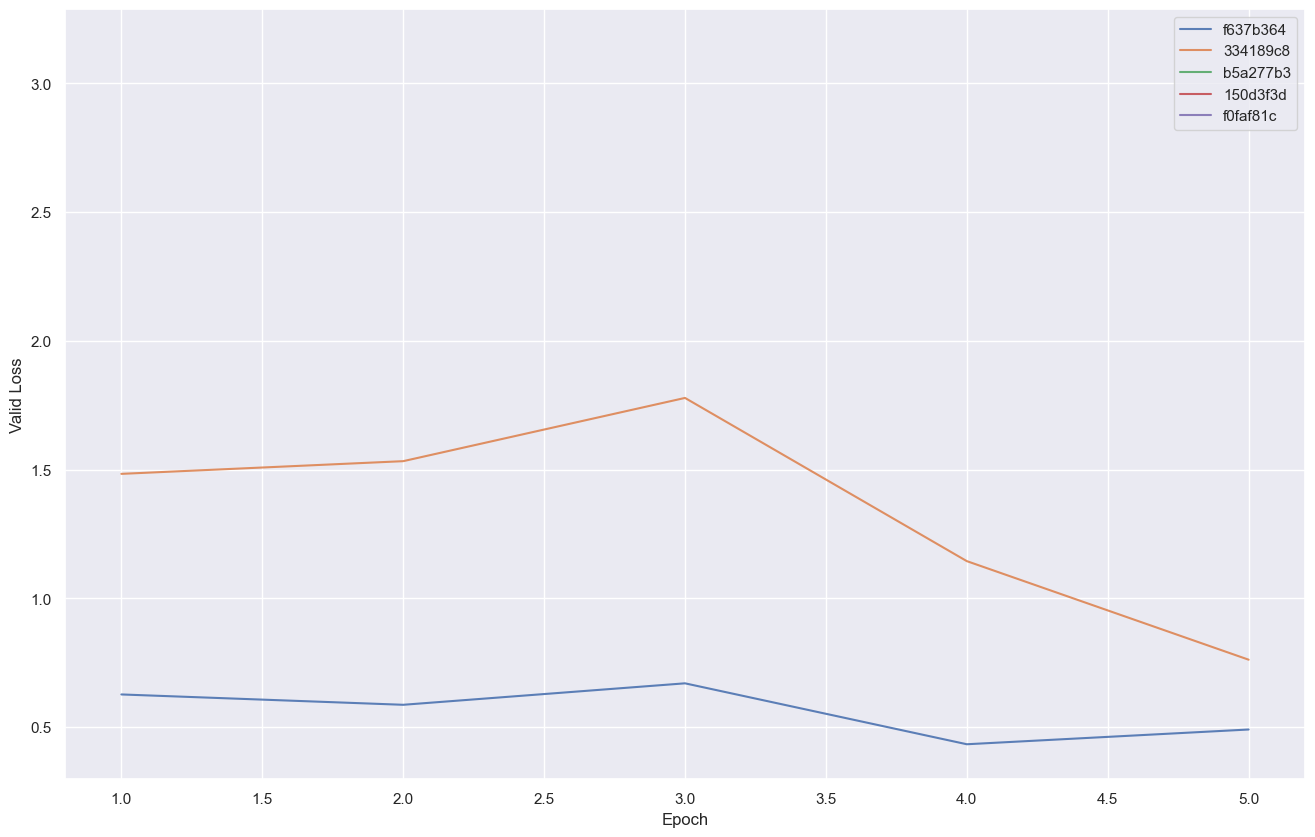

In [19]:
# Plot trials valid loss

raytune_plot.trials_lineplot_loss(
	dataframe  = trials,
	max_trials = 5,
	alpha      = 0.9,
	filename   = os.path.join(OUT_PLOT, CONFIG['model/type'] + '-trials')
)

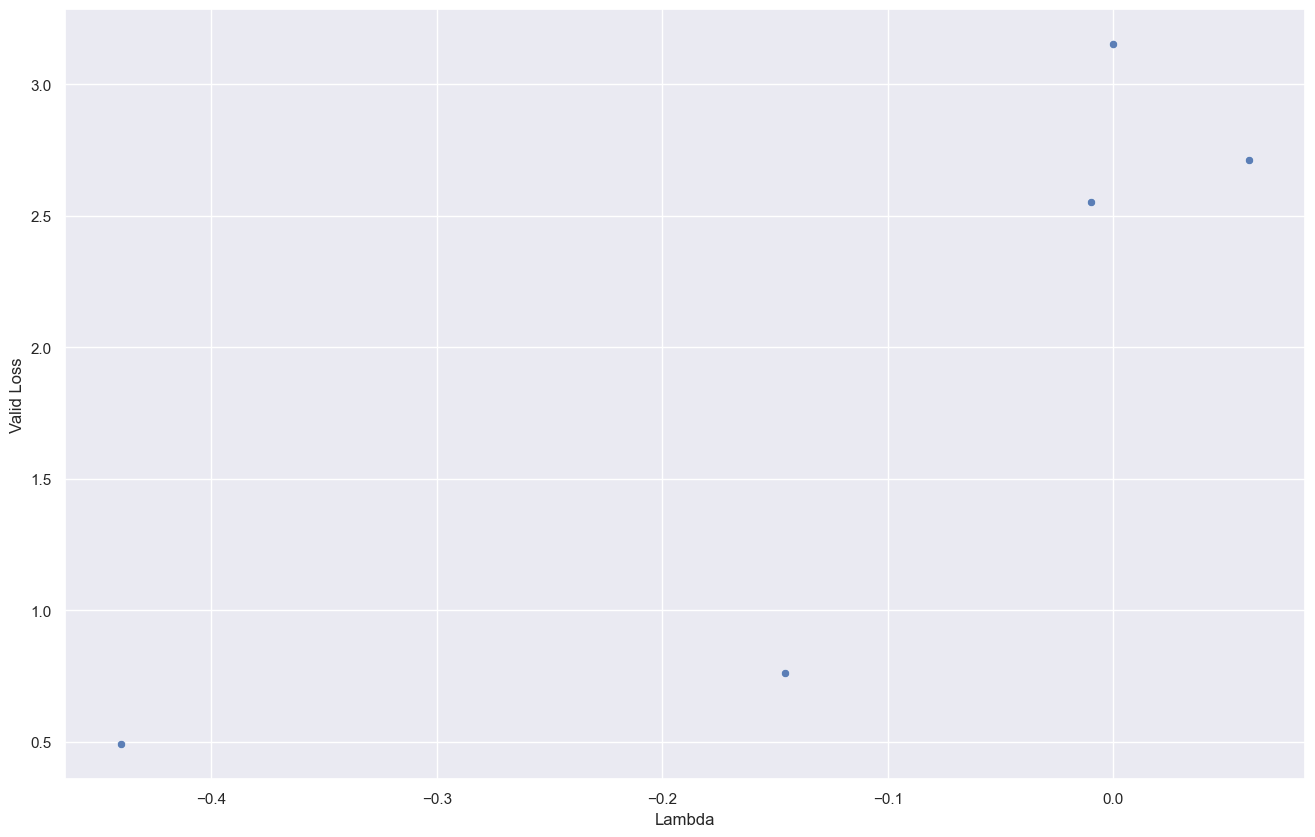

In [20]:
# Plot trials boxcox lambda vs. valid loss; clip loss values to range to bypass extreme values that would descale the plot

raytune_plot.trials_scatterplot_lambda_loss(
	dataframe = dataframe,
	alpha      = 0.9,
	filename   = os.path.join(OUT_PLOT, CONFIG['model/type'] + '-trials'),
	clip       = None
)

### 5.1.1 Regression

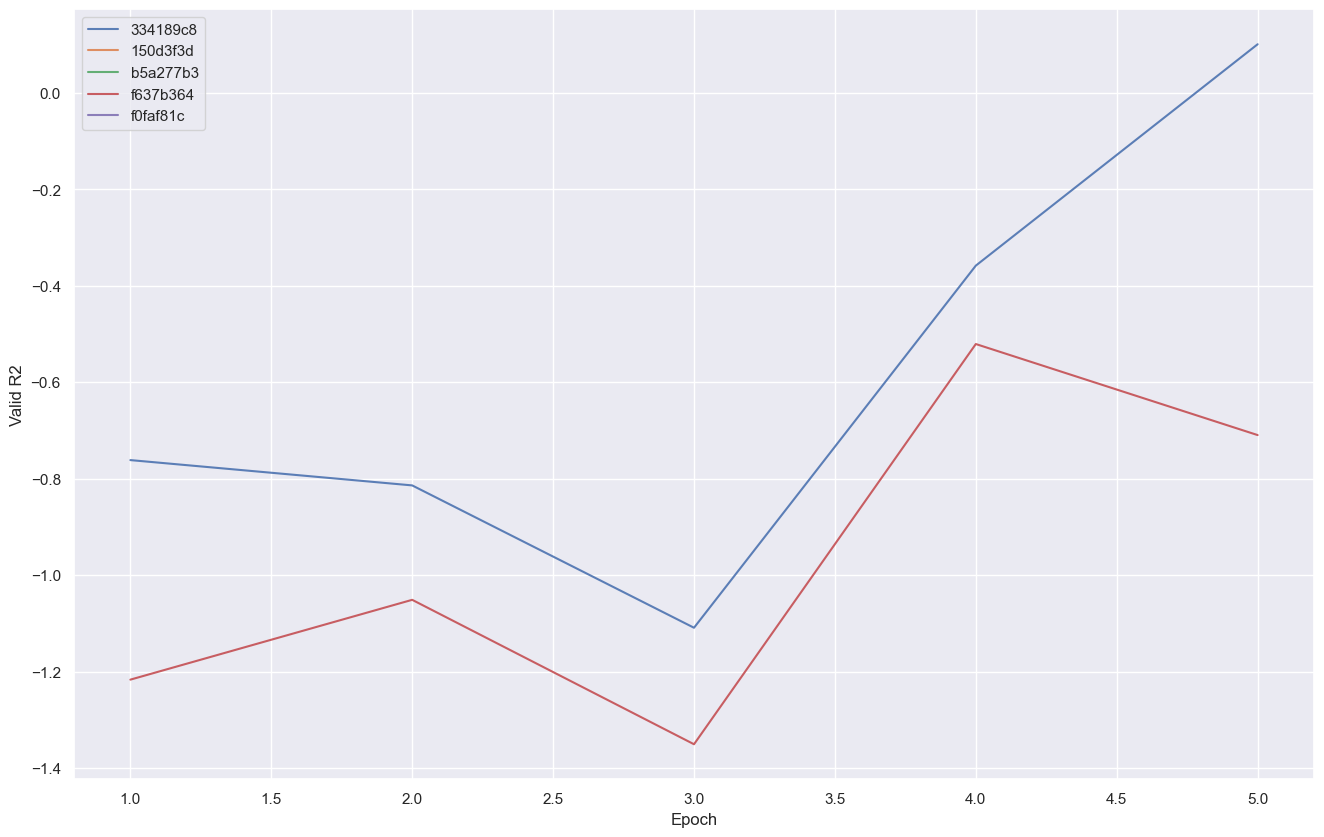

In [21]:
# Plot trials valid r2

if CONFIG['model/mode'] == 'regression' :
	raytune_plot.trials_lineplot_r2(
		dataframe  = trials,
		max_trials = 5,
		alpha      = 0.9,
		filename   = os.path.join(OUT_PLOT, CONFIG['model/type'] + '-trials')
	)

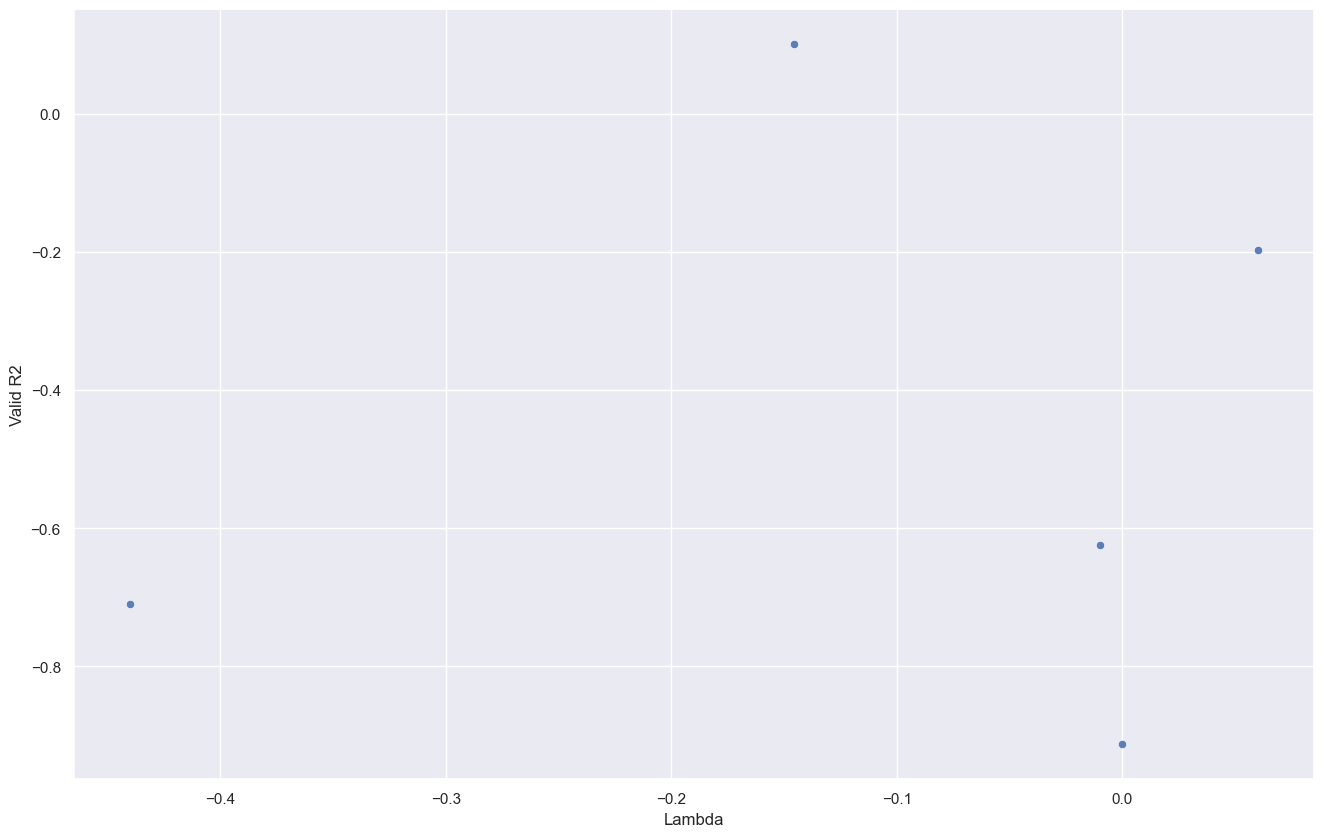

In [22]:
# Plot trials boxcox lambda vs. valid r2; clip r2 values to range to bypass extreme values that would descale the plot

if CONFIG['model/mode'] == 'regression' :
	raytune_plot.trials_scatterplot_lambda_r2(
		dataframe = dataframe,
		alpha      = 0.9,
		filename   = os.path.join(OUT_PLOT, CONFIG['model/type'] + '-trials'),
		clip       = (-2.0, None)
	)

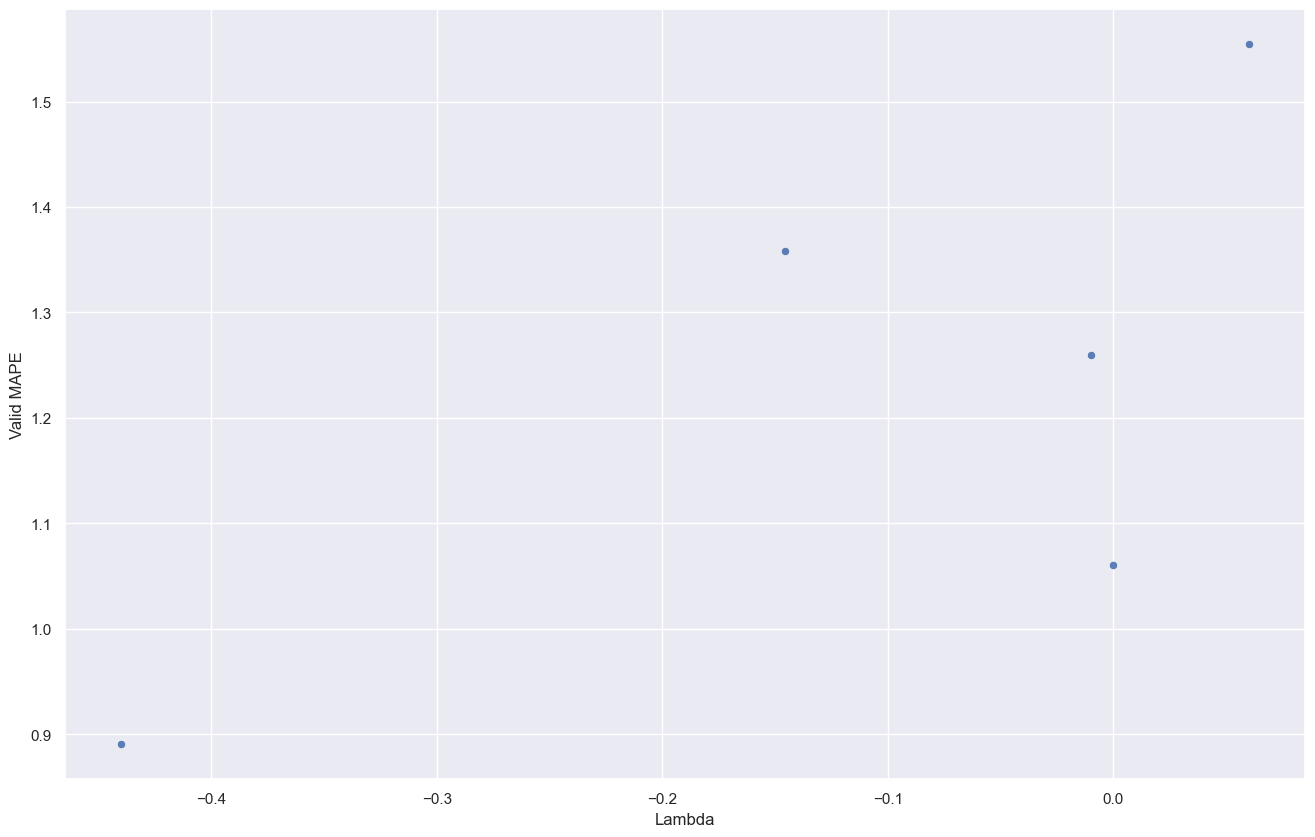

In [23]:
# Plot trials boxcox lambda vs. valid mape; clip mape values to range to bypass extreme values that would descale the plot

if CONFIG['model/mode'] == 'regression' :
	raytune_plot.trials_scatterplot_lambda_mape(
		dataframe = dataframe,
		alpha      = 0.9,
		filename   = os.path.join(OUT_PLOT, CONFIG['model/type'] + '-trials'),
		clip       = None
	)

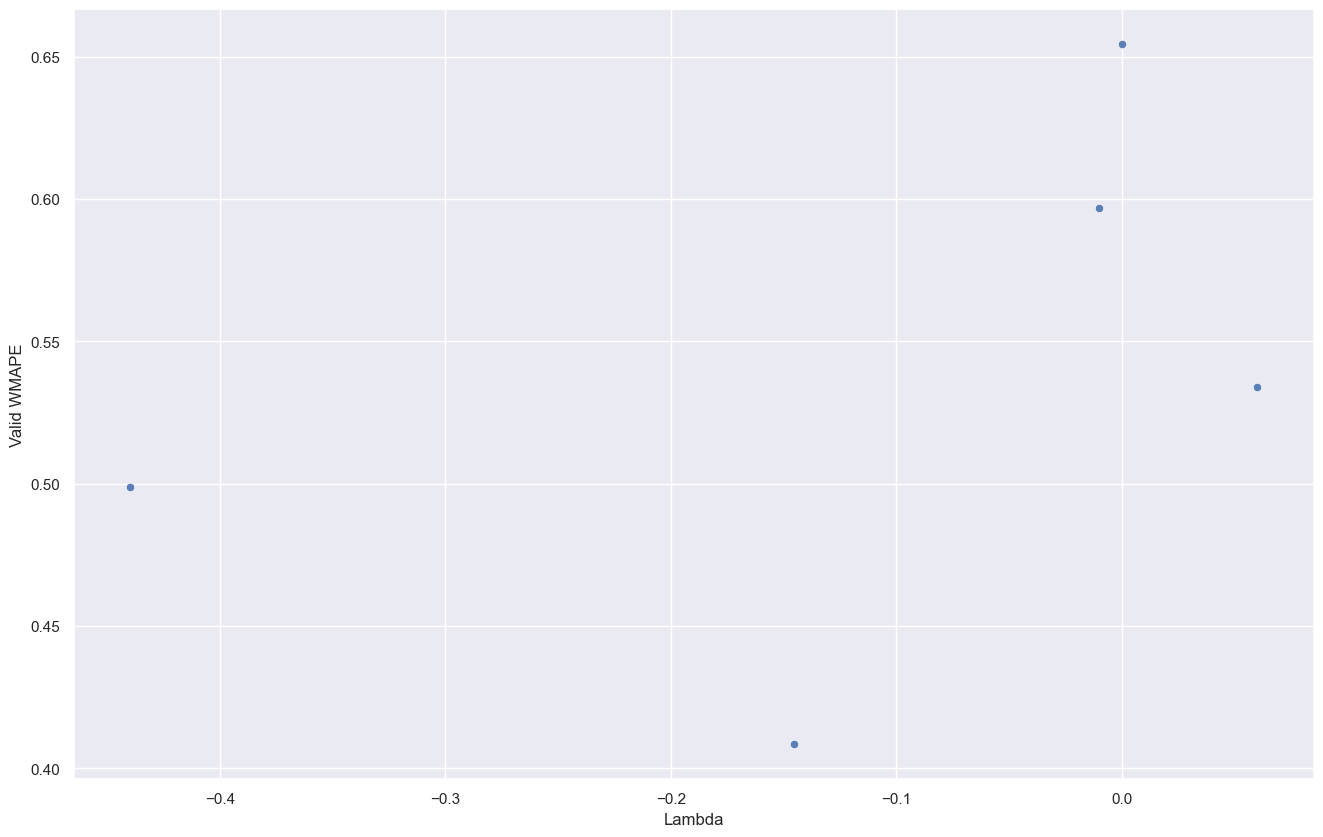

In [24]:
# Plot trials boxcox lambda vs. valid wmape; clip mape values to range to bypass extreme values that would descale the plot

if CONFIG['model/mode'] == 'regression' :
	raytune_plot.trials_scatterplot_lambda_wmape(
		dataframe = dataframe,
		alpha      = 0.9,
		filename   = os.path.join(OUT_PLOT, CONFIG['model/type'] + '-trials'),
		clip       = None
	)

### 5.1.2 Classification

In [25]:
# Plot trials valid accuracy

if CONFIG['model/mode'] == 'classification' :
	raytune_plot.trials_lineplot_accuracy(
		dataframe  = trials,
		max_trials = 5,
		alpha      = 0.9,
		filename   = os.path.join(OUT_PLOT, CONFIG['model/type'] + '-trials')
	)

In [26]:
# Plot trials boxcox lambda vs. valid accuracy; clip accuracy values to range to bypass extreme values that would descale the plot

if CONFIG['model/mode'] == 'classification' :
	raytune_plot.trials_scatterplot_lambda_accuracy(
		dataframe = dataframe,
		alpha      = 0.9,
		filename   = os.path.join(OUT_PLOT, CONFIG['model/type'] + '-trials'),
		clip       = None
	)

In [27]:
# Plot trials boxcox lambda vs. valid auroc; clip auroc values to range to bypass extreme values that would descale the plot

if CONFIG['model/mode'] == 'classification' :
	raytune_plot.trials_scatterplot_lambda_auroc(
		dataframe = dataframe,
		alpha      = 0.9,
		filename   = os.path.join(OUT_PLOT, CONFIG['model/type'] + '-trials'),
		clip       = None
	)

In [28]:
# Plot trials boxcox lambda vs. valid f1; clip f1 values to range to bypass extreme values that would descale the plot

if CONFIG['model/mode'] == 'classification' :
	raytune_plot.trials_scatterplot_lambda_f1(
		dataframe = dataframe,
		alpha      = 0.9,
		filename   = os.path.join(OUT_PLOT, CONFIG['model/type'] + '-trials'),
		clip       = None
	)

In [29]:
# Plot trials boxcox lambda vs. number of classification bins for accuracy

if CONFIG['model/mode'] == 'classification' and CONFIG['tuner/search'] == 'gridsearch' :
	raytune_plot.trials_heatmap_lambda_bins_accuracy(
		dataframe = dataframe,
		filename  = os.path.join(OUT_PLOT, CONFIG['model/type'] + '-trials')
	)

In [30]:
# Plot trials boxcox lambda vs. number of classification bins for f1

if CONFIG['model/mode'] == 'classification' and CONFIG['tuner/search'] == 'gridsearch' :
	raytune_plot.trials_heatmap_lambda_bins_f1(
		dataframe = dataframe,
		filename  = os.path.join(OUT_PLOT, CONFIG['model/type'] + '-trials')
	)

In [31]:
# Plot trials boxcox lambda vs. number of classification bins for auroc

if CONFIG['model/mode'] == 'classification' and CONFIG['tuner/search'] == 'gridsearch' :
	raytune_plot.trials_heatmap_lambda_bins_auroc(
		dataframe = dataframe,
		filename  = os.path.join(OUT_PLOT, CONFIG['model/type'] + '-trials')
	)

In [32]:
# Plot trials boxcox lambda vs. number of classification bins for matthews

if CONFIG['model/mode'] == 'classification' and CONFIG['tuner/search'] == 'gridsearch' :
	raytune_plot.trials_heatmap_lambda_bins_matthews(
		dataframe = dataframe,
		filename  = os.path.join(OUT_PLOT, CONFIG['model/type'] + '-trials')
	)

## 5.2 Best

In [33]:
# Display best trial

best = report.get_best_result()

if CONFIG['model/mode'] == 'regression'     : metrics = ['loss', 'r2', 'mae', 'mape', 'wmape']
if CONFIG['model/mode'] == 'classification' : metrics = ['loss', 'accuracy', 'auroc', 'f1', 'matthews']

for mode, metric in itertools.product(['train', 'valid'], metrics) :
	k0 = 'metrics/{}/{}'.format(mode, metric)
	k1 = '{}_{}'.format(mode, metric)

	best.config[k0] = float(best.metrics[k1])

print('Best config :')
print()
print('{')

for index, (key, val) in enumerate(sorted(best.config.items()), start = 1) :
	if isinstance(key, str)   : key = f'"{key}"'
	if isinstance(val, str)   : val = f'"{val}"'

	if isinstance(val, float) : print('\t{:30s} : {:.16f}'.format(key, val), end = '')
	else                      : print('\t{:30s} : {}'.format(key, val), end = '')

	if index < len(best.config) : print(',')
	else                        : print('')

print('}')

Best config :

{
	"boxcox/lambda"                : -0.4398226524194595,
	"class/bins"                   : 4,
	"metrics/train/loss"           : 0.2440205899915558,
	"metrics/train/mae"            : 0.4076088792869077,
	"metrics/train/mape"           : 1.3156323432922363,
	"metrics/train/r2"             : 0.1448174268007278,
	"metrics/train/wmape"          : 0.3430933058261871,
	"metrics/valid/loss"           : 0.4912263724622724,
	"metrics/valid/mae"            : 0.5918538664682226,
	"metrics/valid/mape"           : 0.8905578255653381,
	"metrics/valid/r2"             : -0.7096052765846252,
	"metrics/valid/wmape"          : 0.4988152980804443
}


In [34]:
# Display per iteration

progress = loader.load_csv(
	filename = os.path.join(best.log_dir, 'progress.csv')
)

if CONFIG['model/mode'] == 'regression' :
	progress = progress[[
		'trial_id', 'time_total_s', 'training_iteration', 'lr',
		'train_loss', 'train_r2', 'train_mae', 'train_mape', 'train_wmape',
		'valid_loss', 'valid_r2', 'valid_mae', 'valid_mape', 'valid_wmape',
	]]

if CONFIG['model/mode'] == 'classification' :
	progress = progress[[
		'trial_id', 'time_total_s', 'training_iteration', 'lr',
		'train_loss', 'train_accuracy', 'train_auroc', 'train_f1', 'train_matthews',
		'valid_loss', 'valid_accuracy', 'valid_auroc', 'valid_f1', 'valid_matthews'
	]]

progress

,trial_id,time_total_s,training_iteration,lr,train_loss,train_r2,train_mae,train_mape,train_wmape,valid_loss,valid_r2,valid_mae,valid_mape,valid_wmape
0,f637b364,286.234,1,0.001,0.444,-0.569,0.525,1.527,0.441,0.627,-1.217,0.682,1.045,0.574
1,f637b364,316.138,2,0.001,0.271,0.047,0.429,1.370,0.362,0.587,-1.051,0.660,0.977,0.556
2,f637b364,346.434,3,0.001,0.255,0.108,0.416,1.350,0.350,0.671,-1.351,0.711,0.893,0.598
3,f637b364,375.922,4,0.001,0.246,0.136,0.410,1.324,0.346,0.434,-0.521,0.568,1.195,0.479
4,f637b364,405.495,5,0.001,0.244,0.145,0.408,1.316,0.343,0.491,-0.710,0.592,0.891,0.499


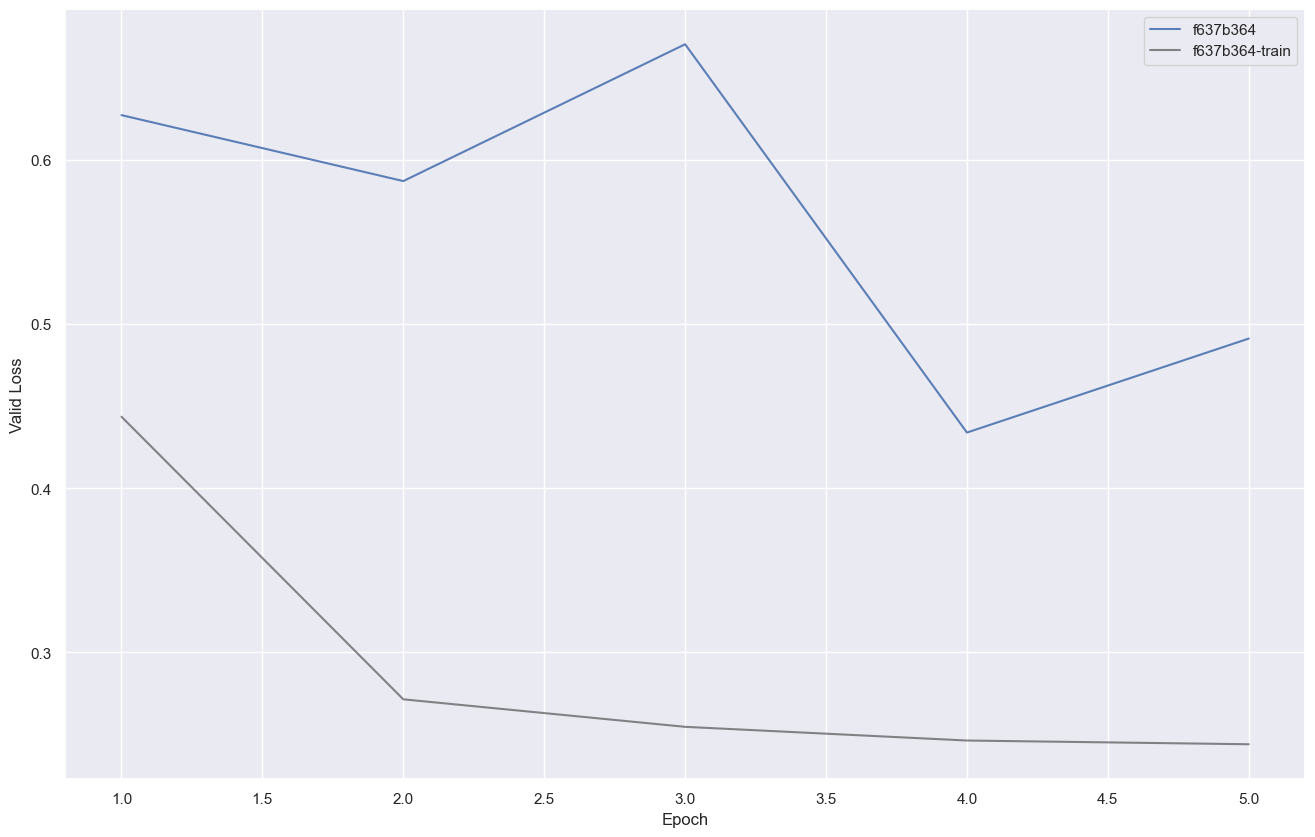

In [35]:
# Plot best trial valid loss

raytune_plot.trial_lineplot_loss(
	dataframe = progress,
	filename  = os.path.join(OUT_PLOT, CONFIG['model/type'] + '-best')
)

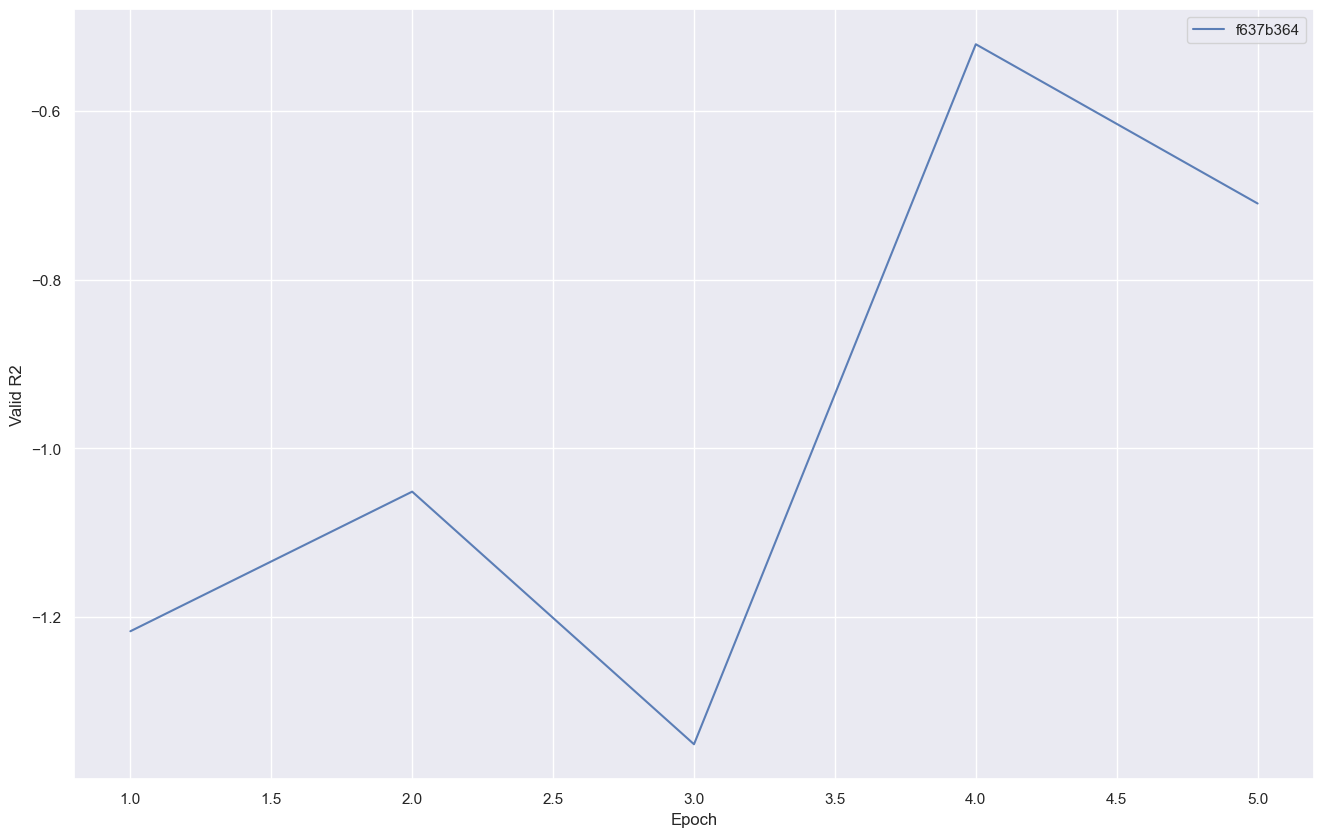

In [36]:
# Plot best trial valid r2

if CONFIG['model/mode'] == 'regression' :
	raytune_plot.trial_lineplot_r2(
		dataframe = progress,
		filename  = os.path.join(OUT_PLOT, CONFIG['model/type'] + '-best')
	)

In [37]:
# Plot best trial valid accuracy

if CONFIG['model/mode'] == 'classification' :
	raytune_plot.trial_lineplot_accuracy(
		dataframe = progress,
		filename  = os.path.join(OUT_PLOT, CONFIG['model/type'] + '-best')
	)

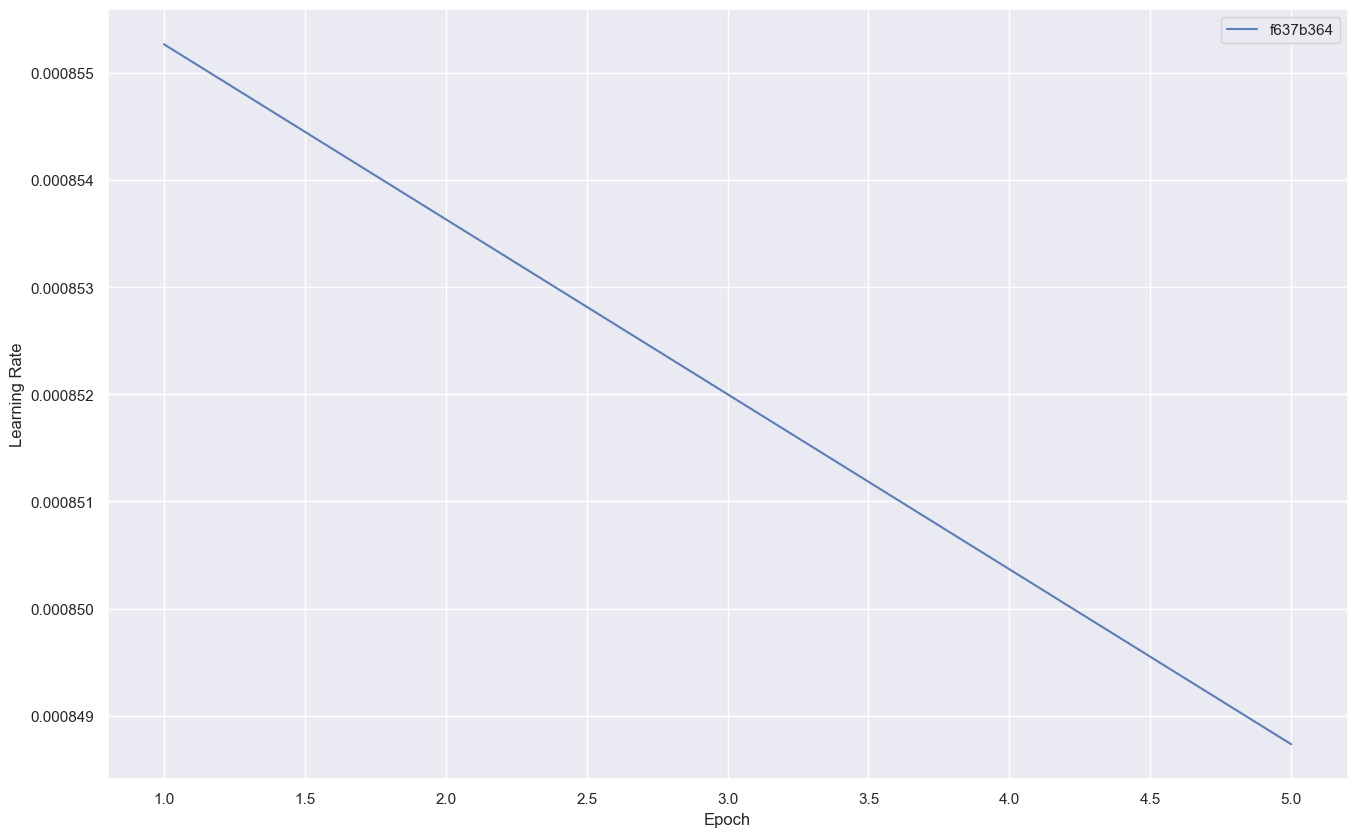

In [38]:
# Plot trials learning rate

raytune_plot.trial_lineplot_lr(
	dataframe = progress,
	filename  = os.path.join(OUT_PLOT, CONFIG['model/type'] + '-best')
)